# **BirdCLEF 2025 Data Preprocessing Notebook**
This notebook demonstrates how we can transform audio data into mel-spectrogram data. This transformation is essential for training 2D Convolutional Neural Networks (CNNs) on audio data, as it converts the one-dimensional audio signals into two-dimensional image-like representations.
I run this public notebook in debug mode(only a few sample processing). You can find the fully preprocessed mel spectrogram training dataset here --> [BirdCLEF'25 | Mel Spectrograms](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms).


In [1]:
import os
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import os
import numpy as np
from datetime import datetime
import pytz
import torch
import warnings
warnings.filterwarnings("ignore")

from module import config_lib, utils_lib

In [2]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'


        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 7 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 128
        self.FMIN = 50
        self.FMAX = 14000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        
        self.seed = 42
            

In [3]:
config = DatasetConfig(kaggle_notebook=False, debug=False)

In [4]:
utils_lib.set_seed(config.seed)

In [5]:
print(f"Debug mode: {'ON' if config.debug else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(f'{config.RAW_DIR}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Loading training metadata...")
train_df = pd.read_csv(f'{config.RAW_DIR}/train.csv')

Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...


In [6]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df[['primary_label', 'rating', 'filename']].copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = config.RAW_DIR + '/train_audio/' + working_df.filename
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [7]:
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

In [8]:
# 並列化

from joblib import Parallel, delayed

def process_row(row):
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        target_samples = int(config.TARGET_DURATION * config.FS)
        if len(audio_data) < target_samples:
            n_copy = math.ceil(target_samples / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
        end_idx = min(len(audio_data), start_idx + target_samples)
        center_audio = audio_data[start_idx:end_idx]

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, (0, target_samples - len(center_audio)), mode='constant')

        mel_spec = audio2melspec(center_audio)

        if mel_spec.shape != config.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        return row.samplename, mel_spec.astype(np.float32), None

    except Exception as e:
        return None, None, (row.filepath, str(e))

results = Parallel(n_jobs=config.N_JOBS)(
    delayed(process_row)(row) for _, row in working_df.iloc[:total_samples].iterrows()
)

# 結果の整理
all_bird_data = {name: spec for name, spec, err in results if name is not None}
errors = [err for name, spec, err in results if err is not None]

In [9]:
import os
import numpy as np
import pickle
import csv
from datetime import datetime
import pytz

# === JST時刻でディレクトリ作成 ===
jst = pytz.timezone('Asia/Tokyo')
now = datetime.now(jst)
timestamp = now.strftime("%Y%m%d_%H%M")
output_dir = os.path.join(config.PROCESSED_DIR, f"melspec_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

# === 1. melスペクトログラムの保存 ===
output_path = os.path.join(output_dir, "birdclef2025_melspec_5sec_256_256.npy")

wrapped_array = np.array(all_bird_data, dtype=object)

with open(output_path, 'wb') as f:
    pickle.dump(wrapped_array, f, protocol=5)

print(f"\n✅ Mel-spectrograms saved to: {output_path}")
print(f"📦 File size: {os.path.getsize(output_path) / (1024 ** 2):.2f} MB")
print(f"📐 Example shape: {next(iter(all_bird_data.values())).shape}")

# === 2. configの保存 ===
config_path = os.path.join(output_dir, "config.csv")

# オブジェクトの属性を key-value に変換（__dict__ で取得）
config_dict = {k: v for k, v in vars(config).items() if not k.startswith("__")}

with open(config_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["key", "value"])
    for key, value in config_dict.items():
        writer.writerow([key, value])

print(f"📝 Config saved to: {config_path}")


✅ Mel-spectrograms saved to: ../data/processed/melspec_20250405_0041/birdclef2025_melspec_5sec_256_256.npy
📦 File size: 7143.48 MB
📐 Example shape: (256, 256)
📝 Config saved to: ../data/processed/melspec_20250405_0041/config.csv


In [59]:
spectrograms = np.load(output_path, allow_pickle=True)


In [56]:
# .npy 読み込み（辞書として）
with open(output_path, 'rb') as f:
    data_dict = pickle.load(f)

In [58]:
data_dict.item()

{'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
         0.68217033],
        [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
         0.669133  ],
        [0.7067035 , 0.7038336 , 0.85138285, ..., 0.69119614, 0.6760983 ,
         0.6430584 ],
        ...,
        [0.21929449, 0.24594525, 0.24758166, ..., 0.2445592 , 0.23815045,
         0.25762546],
        [0.21801782, 0.24828464, 0.24967661, ..., 0.244798  , 0.24452552,
         0.25601286],
        [0.2173795 , 0.24945432, 0.25072408, ..., 0.2449174 , 0.24771307,
         0.25520656]], dtype=float32),
 '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.66954106, ..., 0.83289945, 0.8271354 ,
         0.7059211 ],
        [0.68805015, 0.63310075, 0.6665332 , ..., 0.8213653 , 0.82061225,
         0.71397114],
        [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
         0.73007125],
        ...,
        [0.2316096 , 0.25438875, 0.2436481 , ..., 0.2

In [ ]:
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if config.debug else 'FULL MODE - Processing all samples'}")
start_time = time.time()

all_bird_data = {}
errors = []

for i, row in tqdm(working_df.iterrows(), total=total_samples):
    if config.N_MAX is not None and i >= config.N_MAX:
        break
    
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        target_samples = int(config.TARGET_DURATION * config.FS)

        if len(audio_data) < target_samples:
            n_copy = math.ceil(target_samples / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
        end_idx = min(len(audio_data), start_idx + target_samples)
        center_audio = audio_data[start_idx:end_idx]

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                 (0, target_samples - len(center_audio)), 
                                 mode='constant')

        mel_spec = audio2melspec(center_audio)

        if mel_spec.shape != config.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        all_bird_data[row.samplename] = mel_spec.astype(np.float32)
        
    except Exception as e:
        print(f"Error processing {row.filepath}: {e}")
        errors.append((row.filepath, str(e)))

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
print(f"Failed to process {len(errors)} files")



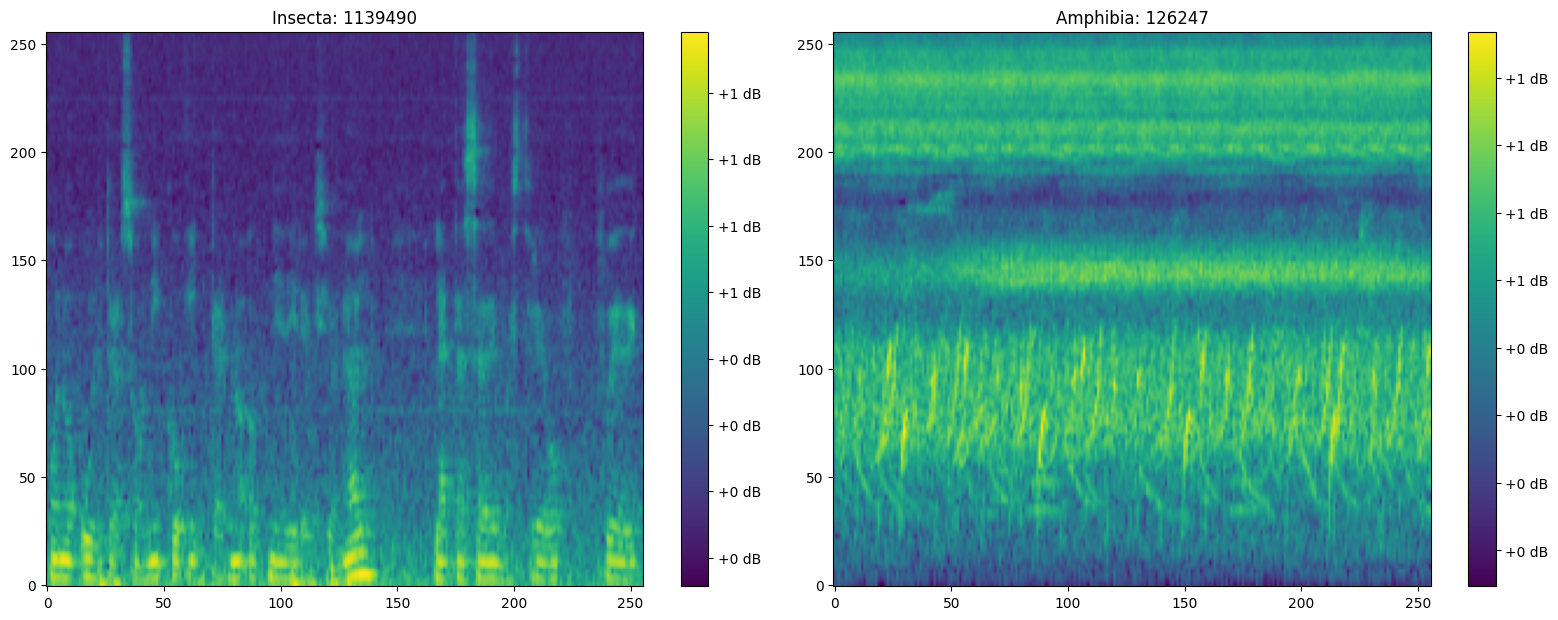

In [27]:
import matplotlib.pyplot as plt

samples = []
displayed_classes = set()

max_samples = min(4, len(all_bird_data))

for i, row in working_df.iterrows():
    if i >= (config.N_MAX or len(working_df)):
        break
        
    if row['samplename'] in all_bird_data:
        if config.debug:
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        else:
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        
        if len(samples) >= max_samples:  
            break

if samples:
    plt.figure(figsize=(16, 12))
    
    for i, (samplename, class_name, species) in enumerate(samples):
        plt.subplot(2, 2, i+1)
        plt.imshow(all_bird_data[samplename], aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"{class_name}: {species}")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    debug_note = "debug_" if config.debug else ""
    plt.show()